In [2]:
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ConstantSpectralModel,
    SkyModel,
    GeneralizedGaussianSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore
from scipy.stats import norm
from regions import CircleSkyRegion
from pathlib import Path
from astropy.coordinates import SkyCoord
import json
import time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# function to add to JSON
def write_json(new_data, filename='sample.json'):
    with open(filename,'r+') as file:
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data.update(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [4]:
config = AnalysisConfig()
config.observations.datastore = ("../")
config.observations.obs_cone.frame = "galactic"
config.observations.obs_cone.lat = "2 deg"
config.observations.obs_cone.radius = "5 deg"

config.datasets.type = "3d"
config.datasets.stack = True
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.axes.energy.max = "100 TeV"
config.datasets.geom.axes.energy.nbins = 10
config.datasets.geom.axes.energy.min = "0.7 TeV"
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "200 TeV"
config.datasets.geom.axes.energy_true.nbins = 20
config.datasets.background.parameters = {"method": "scale"}
config.datasets.background.method = "fov_background"
config.fit.fit_range.min = 0.7 * u.TeV
config.fit.fit_range.max = 100 * u.TeV
config.flux_points.energy = {"min": "0.7 TeV", "max": "100 TeV", "nbins": 10}
config.excess_map.correlation_radius = 0.1 * u.deg

In [5]:
timestr = time.strftime("%Y%m%d-%H%M%S")

with open(f"sliding_window_{timestr}.json", "w") as outfile:
    json.dump({}, outfile)

for i in range(68, 79):
    config.datasets.geom.wcs.skydir = {
        "lon": f"{i} deg",
        "lat": "2.0 deg",
        "frame": "galactic",
    }
    config.observations.obs_cone.lon = f"{i} deg"

    analysis = Analysis(config)
    analysis.get_observations()
    analysis.get_datasets()

    mask_map = Map.read("exclusion_mask.fits")
    mask_map.data = mask_map.data.astype(bool)
    analysis.datasets["stacked"].mask_fit = mask_map

    spectral_model = ConstantSpectralModel(const="1e5 / (cm2 s TeV)")

    spatial_model = GeneralizedGaussianSpatialModel(
        lon_0=i * u.deg,
        lat_0=0 * u.deg,
        eta=.5,
        r_0=12 * u.deg,
        e=.99999,
        phi=90 * u.deg,
        frame="galactic",
    )

    model_config = SkyModel(spectral_model=spectral_model,
                            spatial_model=spatial_model, name="cygnus_background")

    model_config = Models([model_config])
    model_sim = model_config.copy()

    analysis.set_models(model_config, extend=False)
    analysis.models[0].parameters["lon_0"].frozen = True
    analysis.models[0].parameters["r_0"].frozen = True
    analysis.models[1].parameters["norm"].frozen = False
    analysis.models[1].parameters["norm"].value = .1

    analysis.run_fit()

    # Data to be written
    results = {
        str(analysis.fit_result.parameters[1].value): {
            "result": [analysis.fit_result.optimize_result.success, analysis.fit_result.optimize_result.message],
            analysis.fit_result.parameters[0].name: analysis.fit_result.parameters[0].value,
            analysis.fit_result.parameters[2].name: analysis.fit_result.parameters[2].value,
            analysis.fit_result.parameters[4].name: analysis.fit_result.parameters[4].value,
        },
    }
    
    write_json(results, f"sliding_window_{timestr}.json")


Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 55 out of 55.
Number of selected observations: 55
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 3
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3
Running FoVBackgroundMaker
Computing dataset for observation 120
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 120
No default lower safe energy threshold defined for obs 120
Running FoVBackgroundMaker
Computing dataset for observation 147
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 147
No default lower safe energy threshold defined for obs 147
Running FoVBackgroundMaker
Computing d

In [6]:
with open(f"sliding_window_{timestr}.json") as f:
    data = json.load(f)

n_val = len(data[list(data.keys())[0]])
lists = [[] for _ in range(n_val)]

for key, val in data.items():
    lists[0].append(key)
    ls = list(val.values())
    for i in range(1, n_val): lists[i].append(ls[i])


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

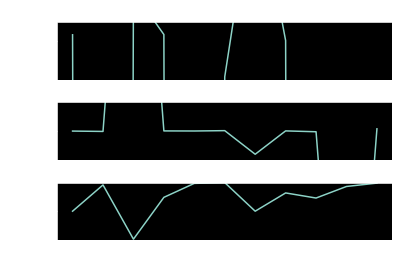

In [7]:
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax[0].semilogy(lists[0], lists[1])
ax[0].set_ylim(1.e-16, 1.e-10)
ax[0].set_title("const")
ax[0].set_ylabel("1 / (cm2 s TeV)")

ax[1].plot(lists[0], lists[2])
ax[1].set_ylim(-5, 5)
ax[1].set_title("lat Position")
ax[1].set_ylabel("deg")

ax[2].plot(lists[0], lists[3])
ax[2].set_ylim(0, 1)
ax[2].set_title("Eta parameter")

# Combine all the operations and display
plt.show()
